<a href="https://colab.research.google.com/github/buttersaltpepper/Financial-Data-Analytics/blob/main/PredictingVolatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Analysis on Market Volatility**
This is where I start to apply what i've learned in data analysis to the financial markets. The reason why i wanted to analyse volatility is because i believe it is easier to estimate and believe volatility is season. It is also extremely useful information for asset managers to understand periods of high volatility. 

Although there is a line between fundamentals and quants, i strongly believe using hard data and numbers will prevent asset managers from getting lost in the rumours and lagging indicators



* Firstly i pulled macroeconomic data which i believe will give a view on the market.
* The data is cleaned and the i calculated post covid rolling volatility
* I visualised the "Sell in May and go away" effect
* Used ANOVA tests with .05% p-value and found out Volatility usually spikes in March (2-months before earnings season), and lasts up to June at a declining rate.
* Then i calculated the Pearson Correlation, p-value, skewness, and kurtosis of the macrocoeconomic data against the SPY volaitlity
* I used this to select relevant features based on effect size and p-value
* then i use these new features to model an OLS
* This model was trained and tested and had an r-squared of 78%.
* Of course theres still more work to do but this is just a glimpse of what I will be focusing on as I continue to learn Statistics, Machine Learning, and Python


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,8)

import statsmodels.api as sm
from scipy import stats

from datetime import datetime, timedelta
import calendar

import yfinance as yf

In [ ]:
tickers_list = ['SPY', 
                'MDY', # MIDCAP
                'EEM', # EMERGY MARKETS
                'EFA', # EAFE
                'IJR', # SMALL CAP
                'VGLT', # LONG-TERM TREASURY 
                'VLUE', # VALUE
                'DVY', # DIVIDEND
                'JPY=X', # USD/JPY
                'BTC-USD', # BTC/USD
                'CL=F', # OIL
                'HO=F', # GAS
                'CL=F', # CORN
                'ZO=F', # OAT
                'ZR=F', # ROUGH RICE
                'ZS=F', # SOYBEAN
                'HE=F', # LEAN HOGS
                'LE=F', # LIVE CATTLE
                'SB=F', # SUGAR
                'GC=F', # GOLD
                'ZN=F', # 10Y T-NOTE FUTURES
                'ZF=F', # 5Y T-NOTE FUTURES
                'ZT=F', # 2Y T-NOTE FUTURES
                'PL=F', # PLATINUM
                'HG=F', # COPPER
                'PA=F', # PALLADIUM
 
]

# **EDA**

In [ ]:
data = yf.download(tickers_list)['Adj Close'].dropna()

[*********************100%***********************]  25 of 25 completed


In [ ]:
# Shift foward
fwrd = 5
rolling_feature = 30

log_rets = np.log(data/data.shift(1))

df = log_rets.rolling(rolling_feature).std()

# df['SPY_vol'] = df.SPY
df['SPY_fwd_vol'] = df.SPY.shift(-fwrd)
df.drop('SPY', axis=1, inplace=True)
df.dropna(inplace=True)
df.head()

,BTC-USD,CL=F,DVY,EEM,EFA,GC=F,HE=F,HG=F,HO=F,IJR,...,SB=F,VGLT,VLUE,ZF=F,ZN=F,ZO=F,ZR=F,ZS=F,ZT=F,SPY_fwd_vol
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-29,0.042859,0.014866,0.008435,0.012009,0.010782,0.007026,0.034209,0.010410,0.010741,0.012349,...,0.018919,0.006523,0.010134,0.002225,0.003196,0.014250,0.007530,0.017191,0.000798,0.010592
2014-10-30,0.041642,0.014841,0.008706,0.012166,0.010766,0.007954,0.034152,0.010279,0.010660,0.012387,...,0.018816,0.006524,0.010213,0.002207,0.003148,0.015482,0.007928,0.017419,0.000798,0.010124
2014-10-31,0.039865,0.014841,0.008782,0.012152,0.011364,0.008814,0.033663,0.010296,0.010649,0.012427,...,0.018583,0.006336,0.010404,0.002223,0.003183,0.015293,0.007992,0.017480,0.000800,0.010043
2014-11-03,0.039907,0.015158,0.008662,0.011934,0.011434,0.008802,0.033609,0.009888,0.010622,0.012234,...,0.017396,0.006340,0.010385,0.002214,0.003172,0.016380,0.007834,0.017367,0.000797,0.010038
2014-11-04,0.036513,0.015376,0.008505,0.011903,0.011385,0.008756,0.033542,0.010283,0.011042,0.012083,...,0.017770,0.006294,0.010370,0.002206,0.003161,0.016453,0.007850,0.017783,0.000795,0.010013


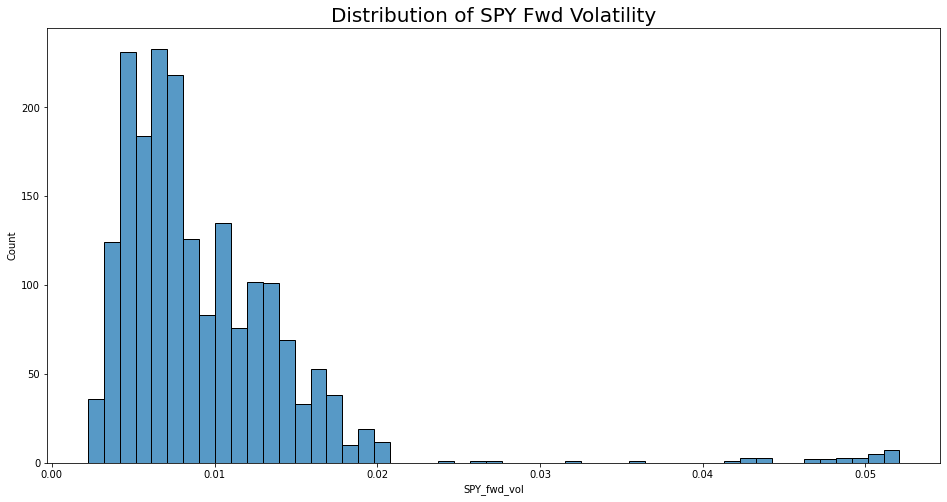

In [ ]:
plt.title('Distribution of SPY Fwd Volatility', fontsize=20)
sns.histplot(df.SPY_fwd_vol);

## **"Sell in May and Go Away" - ANOVA test**
* This is where i visualise and statistically analyse the impact of earnings seasons on market volatility

In [ ]:
def weekinmonth(dates):
    firstday_in_month = dates - pd.to_timedelta(dates.day - 1, unit='d')
    return (dates.day-1 + firstday_in_month.weekday) // 7 + 1
    
df['mnth'] = df.index.month
df['wom'] = weekinmonth(df.index)

In [ ]:
# COVID outlier
post_covid = df[(df.index > '2020-4-1')]
# pre_covid = df[(df.index < '2020-02-1')]

train = post_covid
# train = pd.concat([pre_covid, post_covid])

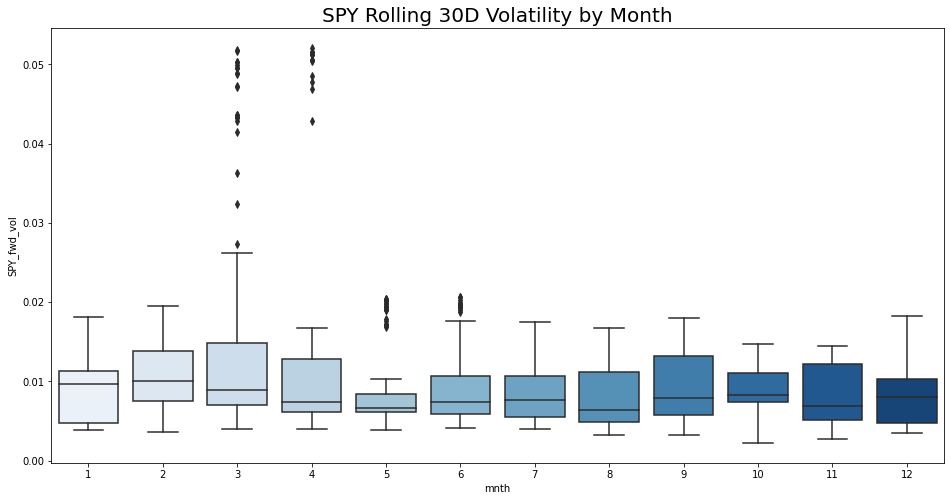

In [ ]:
plt.title('SPY Rolling 30D Volatility by Month', fontsize=20)
sns.boxplot(data=df, x='mnth', y='SPY_fwd_vol', palette='Blues')
plt.show()

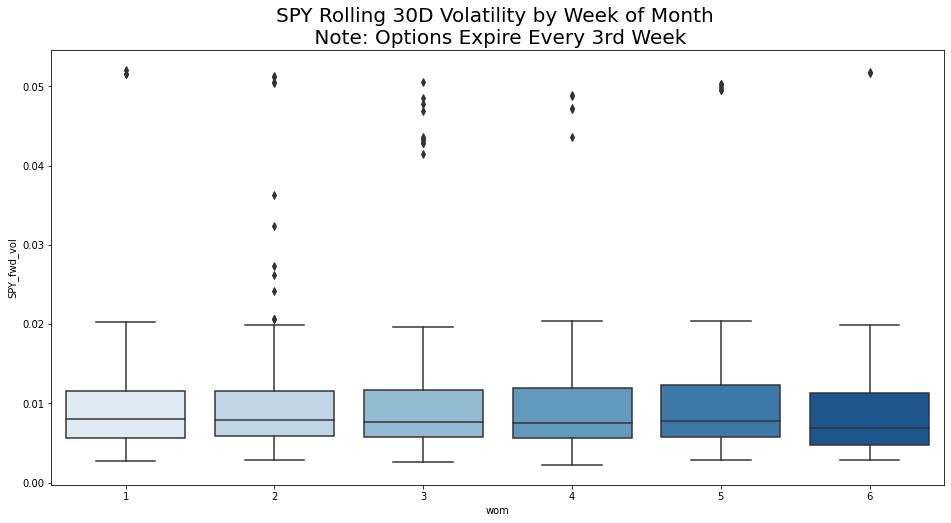

In [ ]:
plt.title('SPY Rolling 30D Volatility by Week of Month \n Note: Options Expire Every 3rd Week', fontsize=20)
sns.boxplot(data=df, x='wom', y='SPY_fwd_vol', palette='Blues')
plt.show()

In [ ]:
anova_df = pd.DataFrame(columns = ['stat', '+/-', 'effect_size', 'p-value', 'skewness', 'kurtosis'])

for feat in df[['mnth', 'wom']]:
  anova_list = df.groupby(feat)['SPY_fwd_vol'].apply(list)
  f, p = stats.f_oneway(*anova_list)

  anova_df.loc[feat] = ['F', '', abs(round(f,3)), round(p,6), '', '']

anova_df.head()

,stat,+/-,effect_size,p-value,skewness,kurtosis
mnth,F,,12.975,0.000000,,
wom,F,,0.669,0.646678,,


## **Pearson Correlation $(r)$ and p-value**

In [ ]:
pearson_df = pd.DataFrame(columns = ['stat', '+/-', 'effect_size', 'p-value', 'skewness', 'kurtosis'])

for col in df.drop('SPY_fwd_vol', axis=1):
  r,p = stats.pearsonr(df[col], df['SPY_fwd_vol'])
  s, k = stats.skew(df[col]), stats.kurtosis(df[col])
  pearson_df.loc[col] = ['r', np.sign(r), abs(round(r,3)), round(p,6), round(s,3), round(k,3)]

pearson_df.sort_values(by=['effect_size', 'p-value'], ascending=False)

,stat,+/-,effect_size,p-value,skewness,kurtosis
VLUE,r,1.0,0.931,0.000000,4.240,25.731
MDY,r,1.0,0.922,0.000000,4.463,28.129
DVY,r,1.0,0.883,0.000000,4.619,29.103
EFA,r,1.0,0.873,0.000000,3.732,20.972
IJR,r,1.0,0.859,0.000000,3.958,22.509
EEM,r,1.0,0.855,0.000000,4.086,24.997
VGLT,r,1.0,0.759,0.000000,3.711,21.644
PA=F,r,1.0,0.738,0.000000,2.911,13.223
CL=F,r,1.0,0.736,0.000000,3.171,15.773
PL=F,r,1.0,0.608,0.000000,1.978,7.508


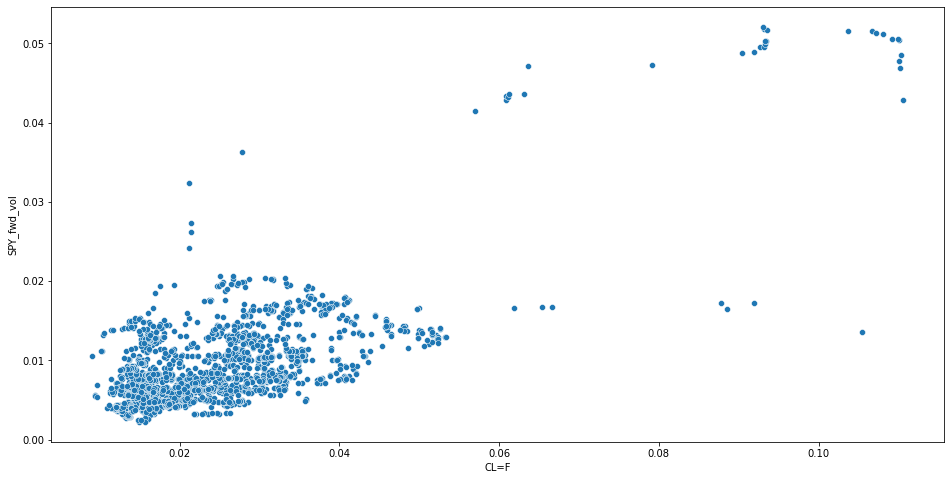

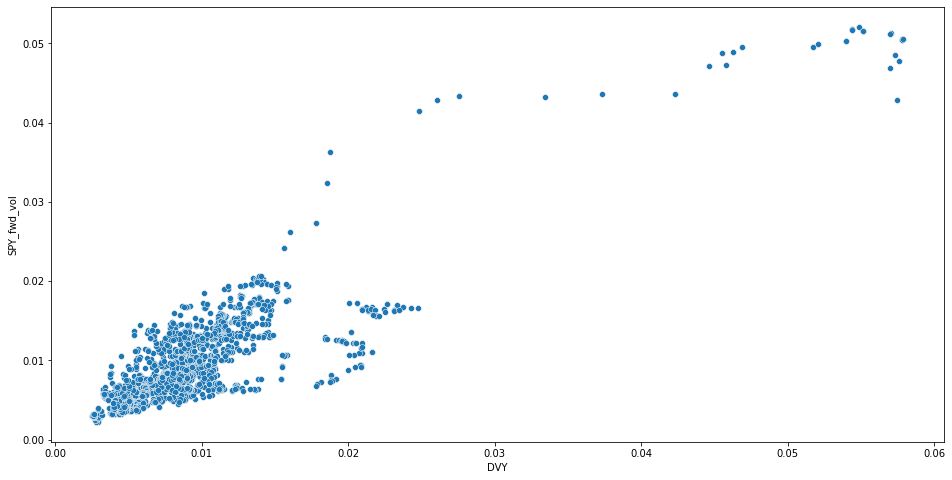

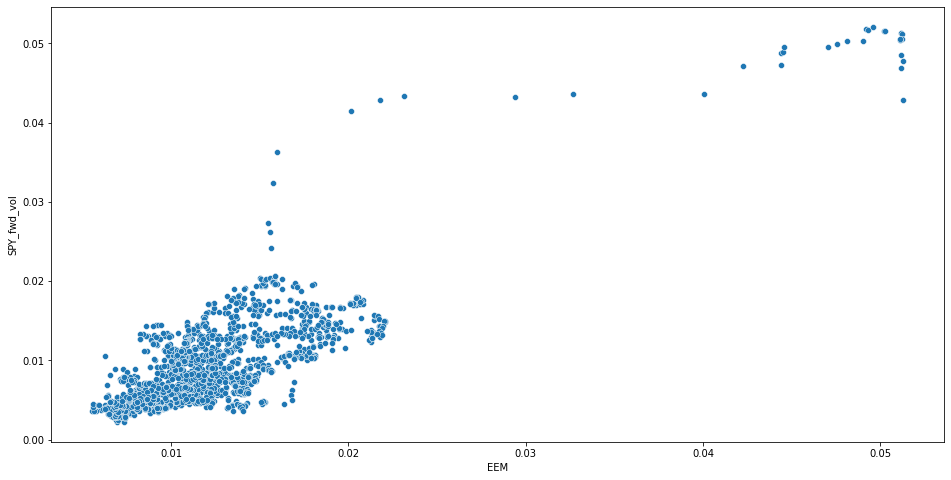

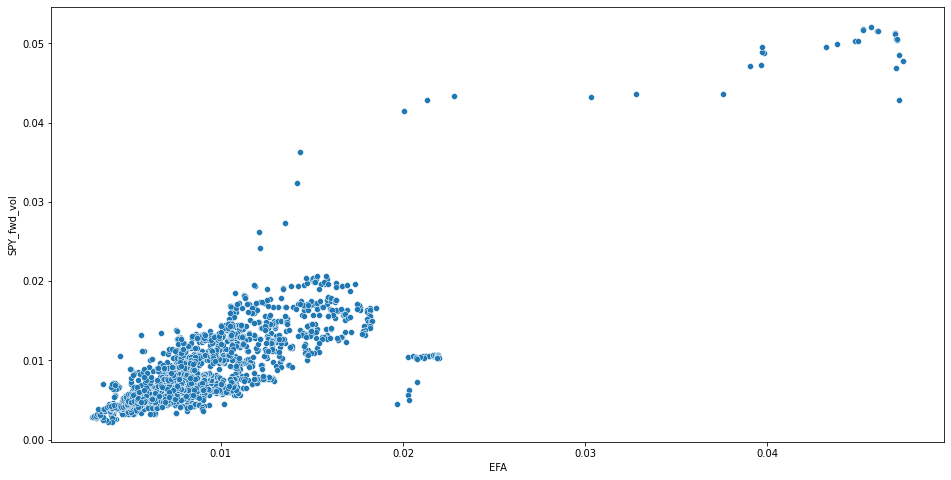

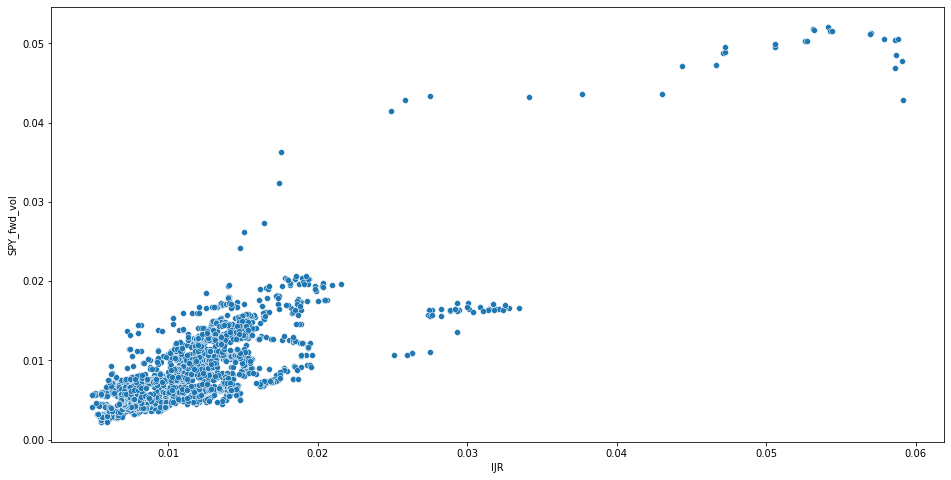

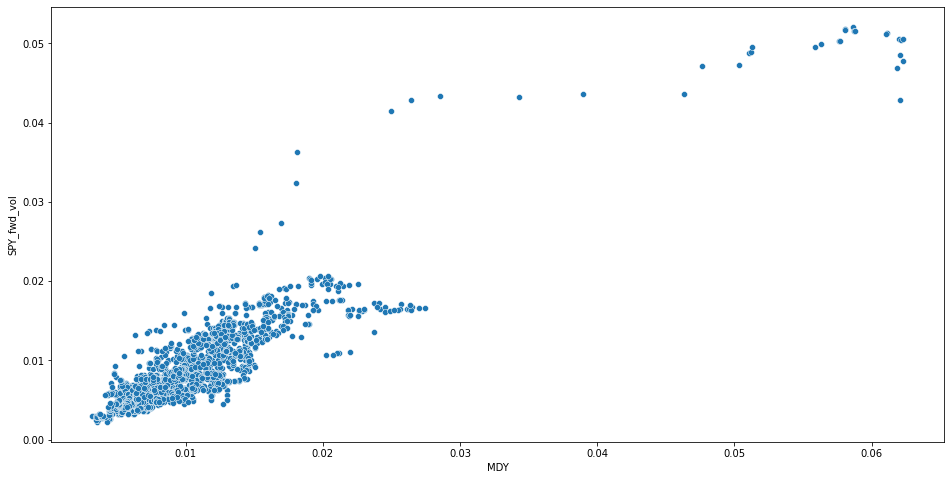

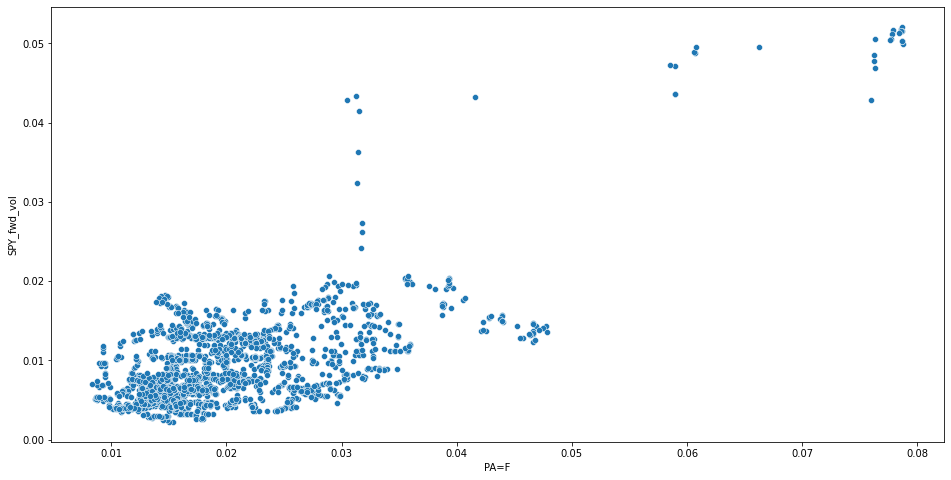

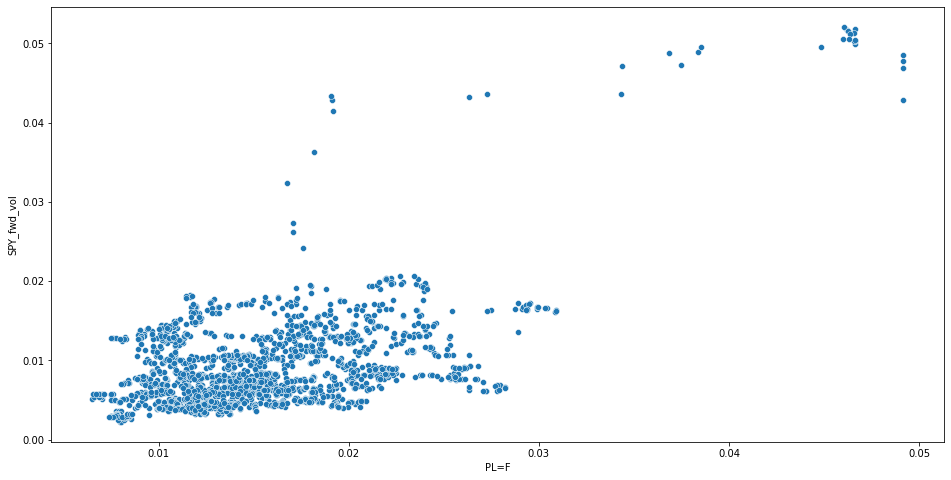

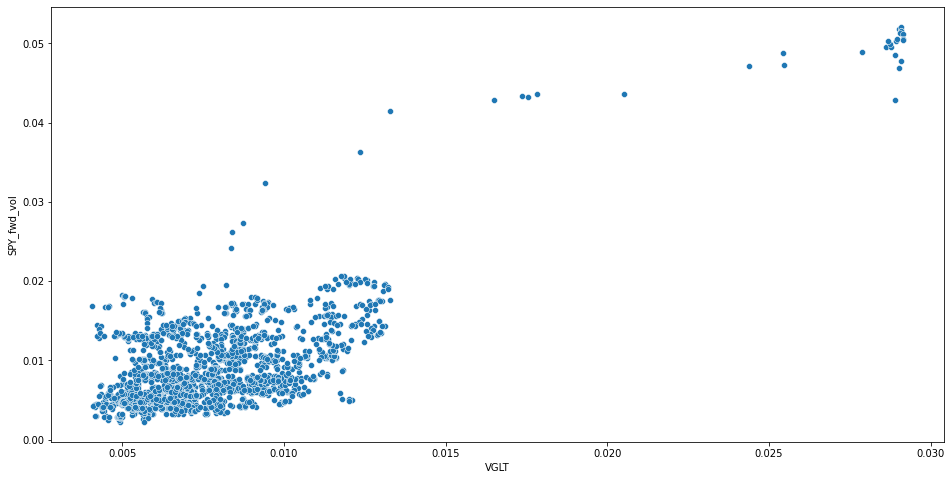

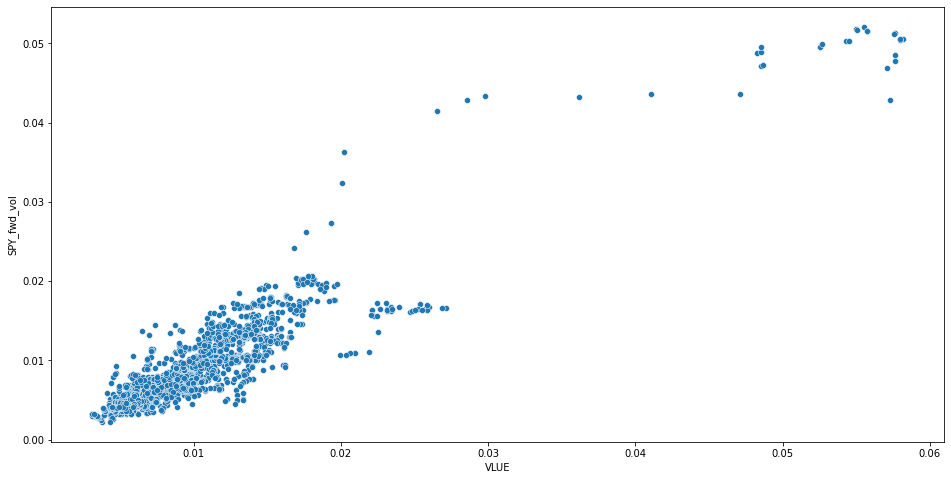

In [ ]:
strong_r = list(pearson_df[pearson_df.effect_size > 0.6].index)

for col in strong_r:
  sns.scatterplot(x=df[col], y=df.SPY_fwd_vol)
  plt.show()

## **Statistical Feature Selection**

In [ ]:
features_table = pd.concat([pearson_df[pearson_df.effect_size > 0.6], anova_df[anova_df['p-value'] < 0.05]])
features_table.sort_values(by=['effect_size', 'p-value'], ascending=[False, True])

,stat,+/-,effect_size,p-value,skewness,kurtosis
mnth,F,,12.975,0.0,,
VLUE,r,1.0,0.931,0.0,4.24,25.731
MDY,r,1.0,0.922,0.0,4.463,28.129
DVY,r,1.0,0.883,0.0,4.619,29.103
EFA,r,1.0,0.873,0.0,3.732,20.972
IJR,r,1.0,0.859,0.0,3.958,22.509
EEM,r,1.0,0.855,0.0,4.086,24.997
VGLT,r,1.0,0.759,0.0,3.711,21.644
PA=F,r,1.0,0.738,0.0,2.911,13.223
CL=F,r,1.0,0.736,0.0,3.171,15.773


In [ ]:
# Very skewed, so assumptions do not hold

# **OLS**
* Sklearn shuffles the data so statsmodels.api may be better for timeseries data

In [ ]:
import statsmodels.api as sm

## Defining and splitting data set

In [ ]:
features = df[features_table.index]

y = df[['SPY_fwd_vol']]
X = features.assign(const=1)

In [ ]:
# manually split data set so it doesnt shuffle like Sklearn
tsize=  0.75

train_size = int(tsize * X.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

print(X_train.shape, y_train.shape, y_test.shape)

(1437, 12) (1437, 1) (480, 1)


## Fitting linear model

In [ ]:
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            SPY_fwd_vol   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     1527.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        07:54:54   Log-Likelihood:                 6944.5
No. Observations:                1437   AIC:                        -1.386e+04
Df Residuals:                    1425   BIC:                        -1.380e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CL=F          -0.0144      0.008     -1.878      0.0

## Prediction

In [ ]:
train_prediction = results.predict(X_train)
test_prediction = results.predict(X_test)

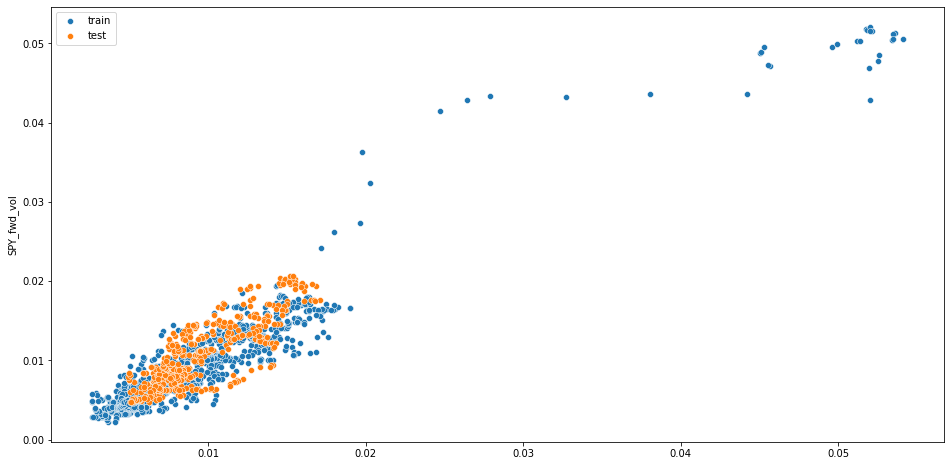

In [ ]:
sns.scatterplot(x=train_prediction, y=y_train.SPY_fwd_vol, label='train')
sns.scatterplot(x=test_prediction, y=y_test.SPY_fwd_vol, label='test')

plt.show()

0.002324636137067133


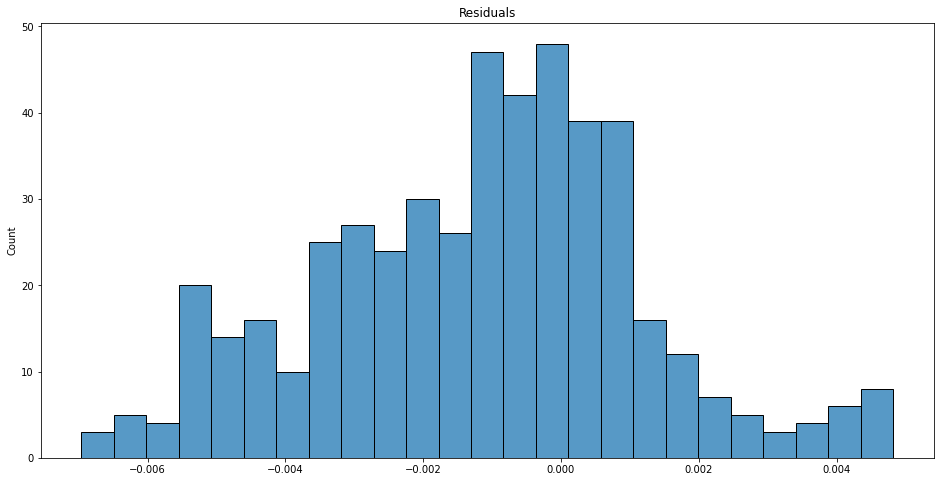

In [ ]:
plt.title('Residuals')
sns.histplot(test_prediction - y_test.SPY_fwd_vol, bins=25);

print(np.std(test_prediction - y_test.SPY_fwd_vol))

## Removing features
* remove the variables that matter the least
* low Coefficient, low t-stat, and high p-value

In [ ]:
# Pull specific results into a dataframe
# t-test is really important for MLR so we can sort by t-stat
features_table = pd.DataFrame({'coef': results.params, 't': abs(results.tvalues), 'p': results.pvalues})
features_table.sort_values(by=['t', 'p'], ascending=[False,True])

,coef,t,p
VLUE,0.735883,14.344333,1.090408e-43
IJR,-0.754658,13.967995,1.191267e-41
const,0.002953,10.243850,8.243065e-24
DVY,0.448334,8.978021,8.499733e-19
MDY,0.525090,6.037551,1.992511e-09
PL=F,-0.116001,5.593173,2.669130e-08
EEM,0.169533,5.574423,2.966267e-08
VGLT,-0.137570,4.219455,2.603593e-05
EFA,-0.091021,2.903731,3.744253e-03
CL=F,-0.014410,1.877987,6.058702e-02


In [ ]:
features_sel = features_table[features_table.p < 0.05] # Drop features over 0.05 p-value
features_sel = features_sel.drop('const')
features_sel

,coef,t,p
DVY,0.448334,8.978021,8.499733e-19
EEM,0.169533,5.574423,2.966267e-08
EFA,-0.091021,2.903731,3.744253e-03
IJR,-0.754658,13.967995,1.191267e-41
MDY,0.525090,6.037551,1.992511e-09
PL=F,-0.116001,5.593173,2.669130e-08
VGLT,-0.137570,4.219455,2.603593e-05
VLUE,0.735883,14.344333,1.090408e-43


# Final OLS model

In [ ]:
features = df[features_sel.index]

X = features.assign(const=1)
y = df[['SPY_fwd_vol']]

In [ ]:
# manually split data set so it doesnt shuffle like Sklearn
tsize=  0.75

train_size = int(tsize * X.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(X_train.shape, y_train.shape, y_test.shape)

(1437, 9) (1437, 1) (480, 1)


In [ ]:
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            SPY_fwd_vol   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     2097.
Date:                Thu, 29 Sep 2022   Prob (F-statistic):               0.00
Time:                        07:54:55   Log-Likelihood:                 6942.2
No. Observations:                1437   AIC:                        -1.387e+04
Df Residuals:                    1428   BIC:                        -1.382e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
DVY            0.4655      0.049      9.534      0.0

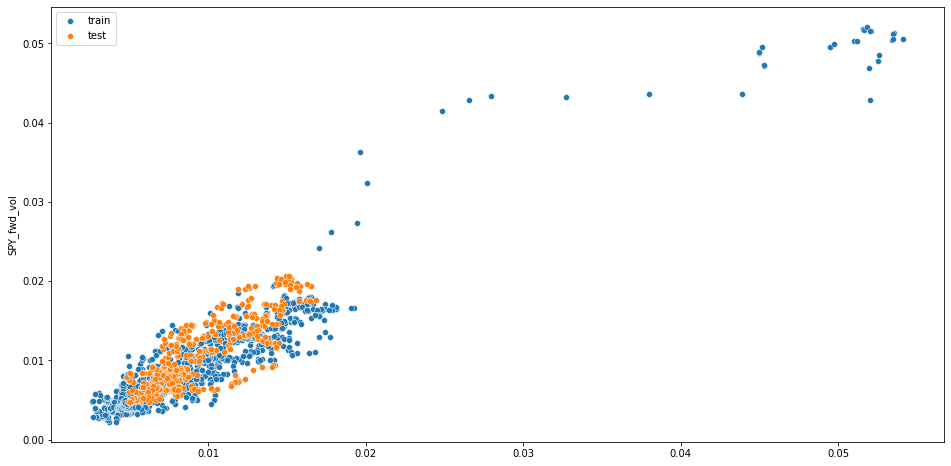

In [ ]:
train_prediction = results.predict(X_train)
test_prediction = results.predict(X_test)

sns.scatterplot(x=train_prediction, y=y_train.SPY_fwd_vol, label='train')
sns.scatterplot(x=test_prediction, y=y_test.SPY_fwd_vol, label='test')

plt.show()

In [ ]:
test_prediction

Date
2020-10-02    0.010869
2020-10-05    0.011185
2020-10-06    0.010573
2020-10-07    0.011112
2020-10-08    0.011383
                ...   
2022-09-13    0.011404
2022-09-14    0.011292
2022-09-15    0.011311
2022-09-16    0.011631
2022-09-19    0.011821
Length: 480, dtype: float64

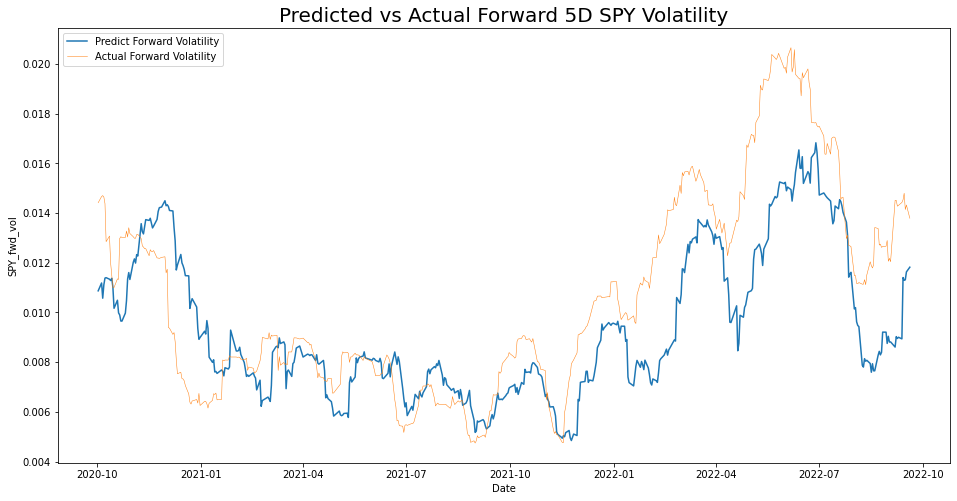

In [ ]:
plt.title('Predicted vs Actual Forward 5D SPY Volatility', fontsize=20)


sns.lineplot(x=test_prediction.index, y=test_prediction, label='Predict Forward Volatility')
sns.lineplot(x=y_test.index, y=y_test.SPY_fwd_vol, linewidth=.5, label='Actual Forward Volatility')
plt.show()

0.0023715346168060674


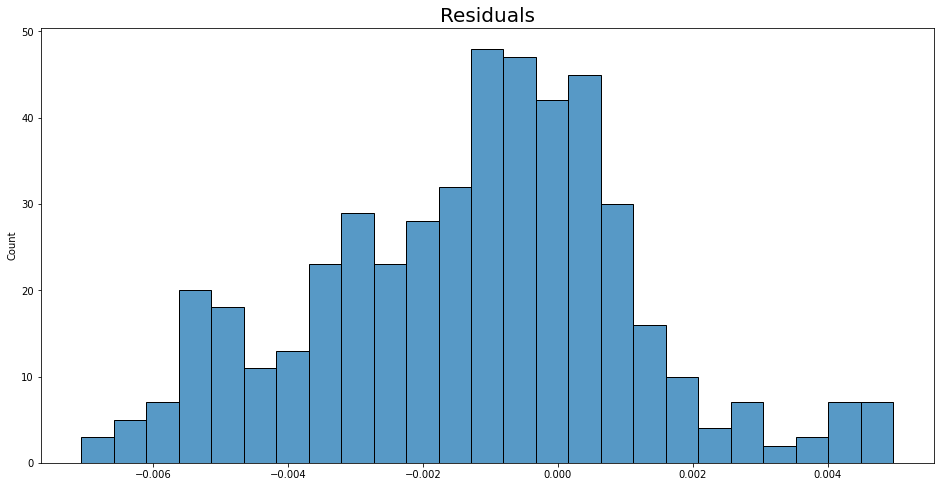

In [ ]:
plt.title('Residuals', fontsize=20)
sns.histplot(test_prediction - y_test.SPY_fwd_vol, bins=25);

print(np.std(test_prediction - y_test.SPY_fwd_vol))
